In [1]:
# Policy Evaluation and Improvement for a Given MDP
# =================================================
# This notebook demonstrates Policy Evaluation and Policy Improvement
# using a simple GridWorld environment.

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
# -------------------------------------------------------------
# 1. Define the MDP environment (same GridWorld as before)
# -------------------------------------------------------------
class GridWorldMDP:
    def __init__(self, grid_size=(4,4), terminal_states=[0, 15], gamma=0.9):
        self.grid_size = grid_size
        self.num_states = grid_size[0] * grid_size[1]
        self.actions = ['U', 'D', 'L', 'R']
        self.gamma = gamma
        self.terminal_states = terminal_states

    def state_to_pos(self, s):
        return (s // self.grid_size[1], s % self.grid_size[1])

    def pos_to_state(self, pos):
        return pos[0]*self.grid_size[1] + pos[1]

    def step(self, s, a):
        if s in self.terminal_states:
            return s, 0

        i, j = self.state_to_pos(s)
        if a == 'U':
            i = max(i-1, 0)
        elif a == 'D':
            i = min(i+1, self.grid_size[0]-1)
        elif a == 'L':
            j = max(j-1, 0)
        elif a == 'R':
            j = min(j+1, self.grid_size[1]-1)

        next_state = self.pos_to_state((i, j))
        reward = -1  # small penalty per move
        return next_state, reward

    def get_transition_probabilities(self):
        # P[s][a] = list of (prob, next_state, reward)
        P = {}
        for s in range(self.num_states):
            P[s] = {}
            for a in self.actions:
                next_state, reward = self.step(s, a)
                P[s][a] = [(1.0, next_state, reward)]
        return P


In [3]:
# -------------------------------------------------------------
# 2. Initialize the MDP and Transition Model
# -------------------------------------------------------------
mdp = GridWorldMDP()
P = mdp.get_transition_probabilities()

print("Sample transitions for state 5:")
pprint(P[5])

# -------------------------------------------------------------
# 3. Policy Evaluation
# -------------------------------------------------------------
def policy_evaluation(policy, P, gamma=0.9, theta=1e-6):
    """Evaluate a given policy."""
    V = np.zeros(len(P))
    while True:
        delta = 0
        for s in range(len(P)):
            if s in mdp.terminal_states:
                continue
            v = 0
            a = policy[s]
            for prob, next_state, reward in P[s][a]:
                v += prob * (reward + gamma * V[next_state])
            delta = max(delta, abs(v - V[s]))
            V[s] = v
        if delta < theta:
            break
    return V


Sample transitions for state 5:
{'D': [(1.0, 9, -1)],
 'L': [(1.0, 4, -1)],
 'R': [(1.0, 6, -1)],
 'U': [(1.0, 1, -1)]}


In [4]:
# -------------------------------------------------------------
# 4. Policy Improvement
# -------------------------------------------------------------
def policy_improvement(V, P, gamma=0.9):
    """Improve policy given current value function."""
    policy = np.zeros(len(P), dtype=str)
    for s in range(len(P)):
        if s in mdp.terminal_states:
            policy[s] = '-'
            continue
        action_values = []
        for a in mdp.actions:
            v = 0
            for prob, next_state, reward in P[s][a]:
                v += prob * (reward + gamma * V[next_state])
            action_values.append(v)
        best_a = mdp.actions[np.argmax(action_values)]
        policy[s] = best_a
    return policy

In [5]:

# -------------------------------------------------------------
# 5. Policy Iteration (Evaluation + Improvement)
# -------------------------------------------------------------
def policy_iteration(P, gamma=0.9):
    """Perform full policy iteration."""
    # Start with a random policy
    policy = np.random.choice(mdp.actions, size=len(P))
    stable = False
    iteration = 0

    while not stable:
        iteration += 1
        print(f"\n=== Policy Iteration {iteration} ===")
        V = policy_evaluation(policy, P, gamma)
        new_policy = policy_improvement(V, P, gamma)

        # Check for stability
        if np.array_equal(policy, new_policy):
            stable = True
        policy = new_policy

        print("Policy:")
        print(policy.reshape(mdp.grid_size))
        print("Value Function:")
        print(V.reshape(mdp.grid_size))

    return V, policy

In [6]:
# -------------------------------------------------------------
# 6. Run Policy Iteration
# -------------------------------------------------------------
V, policy = policy_iteration(P, gamma=0.9)

print("\nFinal Optimal Policy:")
print(policy.reshape(mdp.grid_size))
print("\nFinal Value Function:")
print(V.reshape(mdp.grid_size))


=== Policy Iteration 1 ===
Policy:
[['-' 'L' 'L' 'L']
 ['U' 'L' 'U' 'U']
 ['U' 'U' 'U' 'D']
 ['U' 'U' 'R' '-']]
Value Function:
[[  0.         -10.         -10.         -10.        ]
 [ -9.99999179 -10.         -10.         -10.        ]
 [-10.         -10.         -10.         -10.        ]
 [-10.         -10.         -10.           0.        ]]

=== Policy Iteration 2 ===
Policy:
[['-' 'L' 'L' 'L']
 ['U' 'U' 'U' 'D']
 ['U' 'U' 'D' 'D']
 ['U' 'R' 'R' '-']]
Value Function:
[[ 0.    -1.    -1.9   -2.71 ]
 [-1.    -1.9   -2.71  -3.439]
 [-1.9   -2.71  -3.439 -1.   ]
 [-2.71  -3.439 -1.     0.   ]]

=== Policy Iteration 3 ===
Policy:
[['-' 'L' 'L' 'D']
 ['U' 'U' 'U' 'D']
 ['U' 'U' 'D' 'D']
 ['U' 'R' 'R' '-']]
Value Function:
[[ 0.   -1.   -1.9  -2.71]
 [-1.   -1.9  -2.71 -1.9 ]
 [-1.9  -2.71 -1.9  -1.  ]
 [-2.71 -1.9  -1.    0.  ]]

=== Policy Iteration 4 ===
Policy:
[['-' 'L' 'L' 'D']
 ['U' 'U' 'U' 'D']
 ['U' 'U' 'D' 'D']
 ['U' 'R' 'R' '-']]
Value Function:
[[ 0.   -1.   -1.9  -2.71]
 [

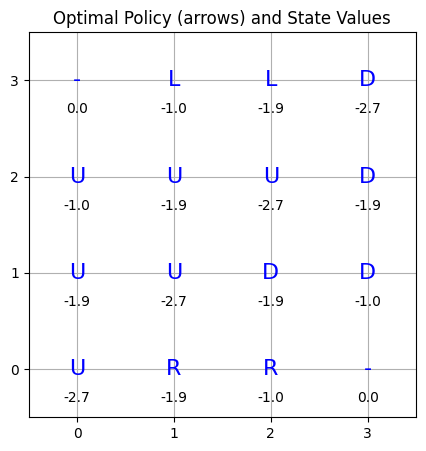

In [7]:
# -------------------------------------------------------------
# 7. Visualization
# -------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,5))
for i in range(mdp.grid_size[0]):
    for j in range(mdp.grid_size[1]):
        s = i*mdp.grid_size[1]+j
        ax.text(j, mdp.grid_size[0]-1-i, policy[s],
                ha='center', va='center', fontsize=16, color='blue')
        ax.text(j, mdp.grid_size[0]-1-i-0.3, f"{V[s]:.1f}",
                ha='center', va='center', fontsize=10, color='black')
ax.set_xticks(np.arange(mdp.grid_size[1]))
ax.set_yticks(np.arange(mdp.grid_size[0]))
ax.set_xlim(-0.5, mdp.grid_size[1]-0.5)
ax.set_ylim(-0.5, mdp.grid_size[0]-0.5)
ax.grid(True)
ax.set_title("Optimal Policy (arrows) and State Values")
plt.show()


In [8]:
# -------------------------------------------------------------
# 8. MDP Simulation under Optimal Policy
# -------------------------------------------------------------
def simulate_mdp(mdp, policy, start_state=5, max_steps=10):
    state = start_state
    total_reward = 0
    print(f"\nStarting simulation from state {state}\n")
    for t in range(max_steps):
        if state in mdp.terminal_states:
            print(f"Reached terminal state {state} at step {t}.")
            break
        action = policy[state]
        next_state, reward = mdp.step(state, action)
        print(f"Step {t}: state={state}, action={action}, reward={reward}, next_state={next_state}")
        total_reward += reward
        state = next_state
    print(f"\nTotal Reward: {total_reward}")

simulate_mdp(mdp, policy)



Starting simulation from state 5

Step 0: state=5, action=U, reward=-1, next_state=1
Step 1: state=1, action=L, reward=-1, next_state=0
Reached terminal state 0 at step 2.

Total Reward: -2
